**Title: RL Vs Gold Deconvolution Algorithm**  
**Author: Ramesh Bhatta, CIS, RIT**

In [1]:
## Import Libraries

import pandas as pd
import numpy as np
import os
import random
import matplotlib.pyplot as plt 
from scipy.signal import fftconvolve
from io import StringIO
import json
import io
from scipy.ndimage import shift as manual_shift

In [2]:
## Predefined plot preferences

# Define text sizes
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

# Apply text size settings
plt.rc('font', size=SMALL_SIZE)          # Default font size
plt.rc('axes', titlesize=MEDIUM_SIZE)   # Axis title font size
plt.rc('axes', labelsize=MEDIUM_SIZE)   # Axis labels font size
plt.rc('xtick', labelsize=SMALL_SIZE)   # X-axis tick label font size
plt.rc('ytick', labelsize=SMALL_SIZE)   # Y-axis tick label font size
plt.rc('legend', fontsize=SMALL_SIZE)   # Legend font size
plt.rc('figure', titlesize=BIGGER_SIZE) # Figure title font size

In [3]:
## Import all the waveform profiles

# Define the directories
recorded_waveform_loc = './16ns_profiles'
true_waveform_loc = './2ns_profiles'

# Initialize dictionaries to store the profiles
recorded_waveforms = {}
true_waveforms = {}

# Function to load column 2 from all waveform profiles in a directory
def load_waveforms(directory):
    waveforms = {}
    for file_name in sorted(os.listdir(directory)):
        if file_name.startswith("profile_") and file_name.endswith(".txt"):  # Adjust extension if needed
            profile_path = os.path.join(directory, file_name)
            data = np.loadtxt(profile_path, usecols=2)  # Load only column 3 (index 2)
            waveforms[file_name] = data 
    return waveforms

# Load the profiles
recorded_waveforms = load_waveforms(recorded_waveform_loc)
true_waveforms = load_waveforms(true_waveform_loc)

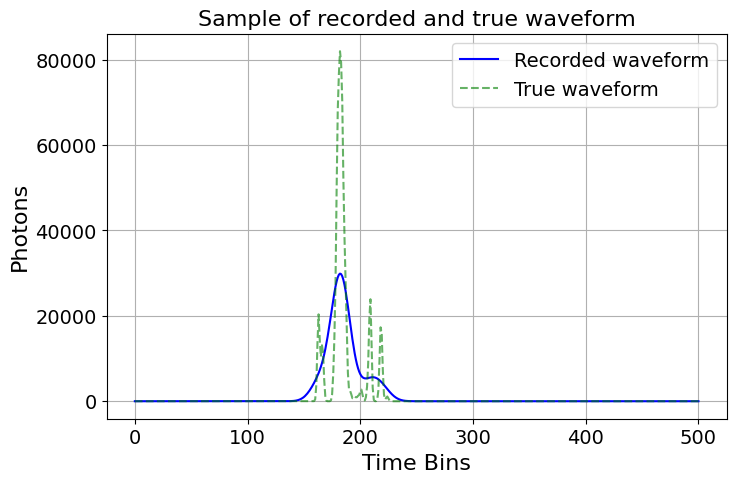

In [4]:
## Plot the sample profile:

plt.figure(figsize=(8,5))
plt.plot(recorded_waveforms['profile_20.txt'], label = 'Recorded waveform', linewidth=1.5, color = 'blue')
plt.plot(true_waveforms['profile_20.txt'], label = 'True waveform', color = 'green', linestyle='dashed', alpha=0.6)
plt.ylabel('Photons')
plt.xlabel('Time Bins')
plt.grid()
plt.title('Sample of recorded and true waveform')
plt.legend()
plt.show()

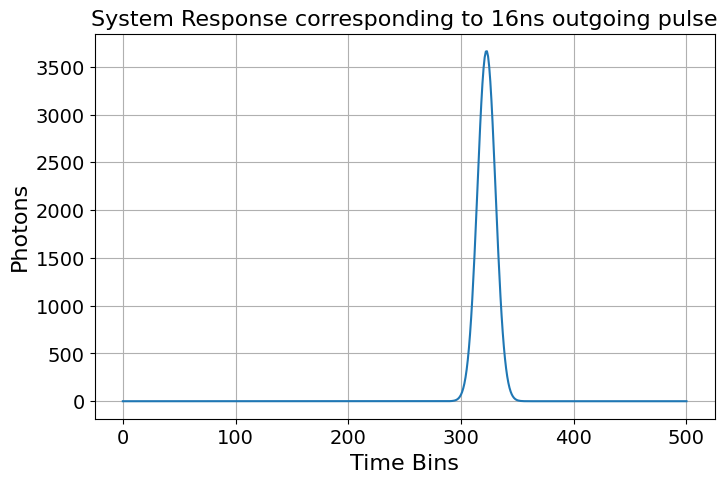

In [5]:
## Import System contribution signal (System Response).

system_response_loc = './16ns_profiles/lambertian_response.txt'
sys_contr_16ns_df = pd.read_csv(system_response_loc, sep=" ", header=None)
sys_contr_16ns = sys_contr_16ns_df[2].values

# Plot the system response:

plt.figure(figsize=(8,5))
plt.plot(sys_contr_16ns)
plt.ylabel('Photons')
plt.xlabel('Time Bins')
plt.grid()
plt.title('System Response corresponding to 16ns outgoing pulse')
plt.show()

### **Deconvolution Algorithms**

### **1. Richardson Lucy Algorithm**

In [6]:
# ## 1 --> Richardson Lucy Deconvolution Algorithm with Boosting

# Helper function to manually shift the deconvolved signal to correct for alignment
def manual_shift(signal, shift):
    """Manually shift a 1D signal."""
    return np.roll(signal, shift)

# Define function
def richardson_lucy_deconvolution_boosted(P_t, R_t, num_iterations, num_repetitions, boosting_coefficient, positivity=True):
    """
    Apply the Richardson-Lucy deconvolution algorithm with Tikhonov regularization,
    time shift correction, and plot residual convergence.

    Parameters:
    - P_t: Observed LiDAR waveform (1D array)
    - R_t: System response function (1D array, same size as P_t)
    - num_iterations: Number of iterations to perform
    - reg_param: Regularization parameter for Tikhonov
    - positivity: If True, enforce positivity constraint
    - adding boosting too

    Returns:
    - P_delta: Deconvolved LiDAR waveform after `num_iterations`
    - residuals: List of residuals (convergence over iterations)
    """
    # Pad the observed waveform and system response to reduce boundary effects
    pad_len = len(R_t) // 2
    P_t_padded = np.pad(P_t, pad_len, mode='constant')
    R_t_padded = np.pad(R_t, pad_len, mode='constant')

    # Initialize the deconvolved signal with a flat guess
    P_delta = np.ones_like(P_t_padded)

    for r in range(num_repetitions):
        
        # print(f"Repetition {r+1} out of {num_repetitions}")
        
        # Iterate the RL algorithm
        for i in range(num_iterations):
            P_delta_previous = P_delta.copy()
            
            # Full convolution of the current estimate with the system response
            convolved = fftconvolve(P_delta, R_t_padded, mode='same')
    
            # Compute the ratio P(t) / (R * P_delta)
            ratio = P_t_padded / (convolved + 1e-10)  # Avoid division by zero
    
            # Convolve the ratio with the flipped system response
            correction = fftconvolve(ratio, R_t_padded[::-1], mode='same')
            P_delta *= correction
    
            # Enforce positivity constraint if enabled
            if positivity:
                P_delta = np.maximum(P_delta, 0)
        
        # After n iterations, apply the boosting function to the current solution
        if r < num_repetitions - 1:  
            P_delta = np.power(P_delta, boosting_coefficient)
            # print(f"Boosting applied with power {boosting_coefficient}")
            
    # Energy-based post-scaling to match the original signal energy
    def apply_energy_scaling(P_delta_t_est, P_t):
        energy_P_t = np.sum(np.abs(P_t) ** 2)
        energy_P_delta_t_est = np.sum(np.abs(P_delta_t_est) ** 2)
        scale_factor = np.sqrt(energy_P_t / energy_P_delta_t_est) if energy_P_delta_t_est > 0 else 1.0
        return P_delta_t_est * scale_factor

    # Apply energy-based post-scaling
    P_delta_scaled = apply_energy_scaling(P_delta , P_t)
    
    # Trim the result to the original signal size
    P_delta_trimmed = P_delta_scaled[pad_len:-pad_len]
    
    # Cross-correlation to estimate the shift between P(t) and deconvolved P_delta
    cross_corr = np.correlate(P_t, P_delta_trimmed, mode='full')
    shift_index = np.argmax(cross_corr) - len(P_t) + 1
    
    # Apply manual shift to correct alignment
    P_delta_shifted = manual_shift(P_delta_trimmed, shift=shift_index)
    
    return P_delta_shifted

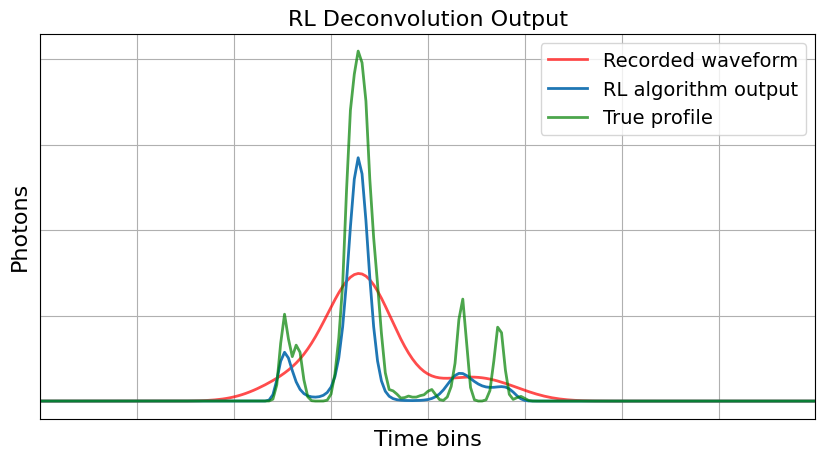

In [7]:
## Sample results for RL algorithm:

num_iterations = 100
boosting_param = 1.25
num_repetititons = 5

# 16ns pw
profile = 'profile_20.txt'
P_t_16ns = recorded_waveforms[profile]
true_response = true_waveforms[profile]
R_t_16ns = sys_contr_16ns

# calling the function
P_deconvolved_RLboosted= richardson_lucy_deconvolution_boosted(P_t_16ns, R_t_16ns, num_iterations, num_repetititons, boosting_param)

# Plot the results
fig = plt.figure(figsize=(10, 5))
plt.plot(P_t_16ns, label='Recorded waveform', color='red', alpha=0.7, linewidth=2)
plt.plot(P_deconvolved_RLboosted, label=f'RL algorithm output', linewidth=2)
plt.plot(true_response, label='True profile', color='green', alpha=0.7, linewidth=2)
plt.grid(which='both')
plt.legend()
plt.xlim(100, 300)
plt.xlabel('Time bins')
plt.ylabel('Photons')

# Remove y-axis values
plt.gca().set_yticklabels([])  # Remove y-axis tick labels
plt.gca().tick_params(axis='y', which='both', length=0)  # Remove y-axis tick marks

# Remove x-axis values
plt.gca().set_xticklabels([])  # Remove x-axis tick labels
plt.gca().tick_params(axis='x', which='both', length=0)  # Remove x-axis tick marks

plt.title('RL Deconvolution Output')
plt.show()

### **2. Gold Deconvolution**

Gold deconvolution (for positive response and output data) gives always positive result. The result of Gold deconvolution is intrinsically constrained to the subspace of positive solutions. Good result for Gold deconvolution is obtained by employing boosting operation. 

In [8]:
# ## 2 ---> Gold Algorithm: One fold gold deconvolution + Boosting

# Construct the Toeplitz matrix for convolution
def toeplitz_matrix(h, len_x):
    """Creates a Toeplitz matrix from the filter h for convolution."""
    len_h = len(h)
    T = np.zeros((len_x + len_h - 1, len_x))
    for i in range(len_h):
        T[i:i + len_x, i] = h
    return T

# Define Bosted one fold gold deconvolution algorithm
def boosted_gold_deconvolution(P_t, R_t, num_iterations, num_repetitions, boosting_coefficient, positivity=True):

    y = P_t

    ## pad y to make dimensions match for calculating H^T y
    pad_len = len(y) // 2 
    y_padded = np.pad(y, (pad_len, pad_len), mode = 'constant')
    
    # Create toeplitz matrix H from R_t
    H = toeplitz_matrix(R_t, len(P_t))

    # Calculate y' = H^T y
    y_prime = H.T @ y_padded
    H_T_H = H.T @ H

    # initial value of P_delta 
    P_delta = np.ones_like(P_t)

# Repeat for each repititions
    for r in range(num_repetitions):
        # print(f'Repetititon {r+1}')
        
        # Repeat for 'n' ierations
        for i in range(num_iterations):
           
            P_delta_est = y_prime / (H_T_H @ P_delta) 
            P_delta_new = P_delta_est * P_delta
            P_delta = P_delta_new
            
            # Enforce positivity constraint if enabled
            if positivity:
                P_delta = np.maximum(P_delta, 0)

        if r < num_repetitions - 1:
            P_delta = np.power(P_delta, boosting_coefficient)

    # Energy-based post-scaling to match the original signal energy
    def apply_energy_scaling(P_delta_t_est, P_t):
        energy_P_t = np.sum(np.abs(P_t) ** 2)
        energy_P_delta_t_est = np.sum(np.abs(P_delta_t_est) ** 2)
        scale_factor = np.sqrt(energy_P_t / energy_P_delta_t_est) if energy_P_delta_t_est > 0 else 1.0
        return P_delta_t_est * scale_factor

    # Apply energy-based post-scaling
    P_delta_scaled = apply_energy_scaling(P_delta, P_t)
    
    # Cross-correlation to estimate the shift between P(t) and deconvolved P_delta
    cross_corr = np.correlate(P_t, P_delta_scaled, mode='full')
    shift_index = np.argmax(cross_corr) - len(P_t) + 1
    
    # Apply manual shift to correct alignment
    P_delta_shifted = manual_shift(P_delta_scaled, shift=shift_index)
    
    return P_delta_shifted

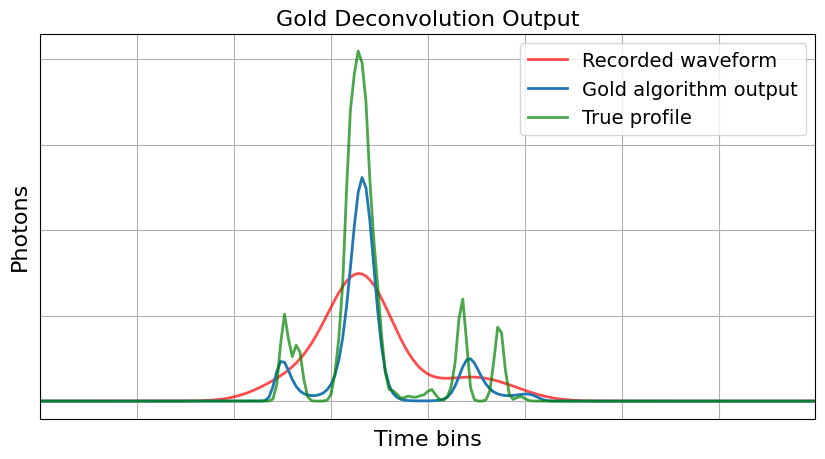

In [9]:
## Sample results for Gold Algorithm:


# Calling the function
P_deconvolved_goldboosted= boosted_gold_deconvolution(P_t_16ns, R_t_16ns, num_iterations, num_repetititons, boosting_param)

# Plot the results
fig = plt.figure(figsize=(10, 5))
plt.plot(P_t_16ns, label='Recorded waveform', color='red', alpha=0.7, linewidth=2)
plt.plot(P_deconvolved_goldboosted, label=f'Gold algorithm output', linewidth=2)
plt.plot(true_response, label='True profile', color='green', alpha=0.7, linewidth=2)
plt.grid(which='both')
plt.legend()
plt.xlim(100, 300)
plt.xlabel('Time bins')
plt.ylabel('Photons')

# Remove y-axis values
plt.gca().set_yticklabels([])  # Remove y-axis tick labels
plt.gca().tick_params(axis='y', which='both', length=0)  # Remove y-axis tick marks

# Remove x-axis values
plt.gca().set_xticklabels([])  # Remove x-axis tick labels
plt.gca().tick_params(axis='x', which='both', length=0)  # Remove x-axis tick marks

plt.title('Gold Deconvolution Output')
plt.show()

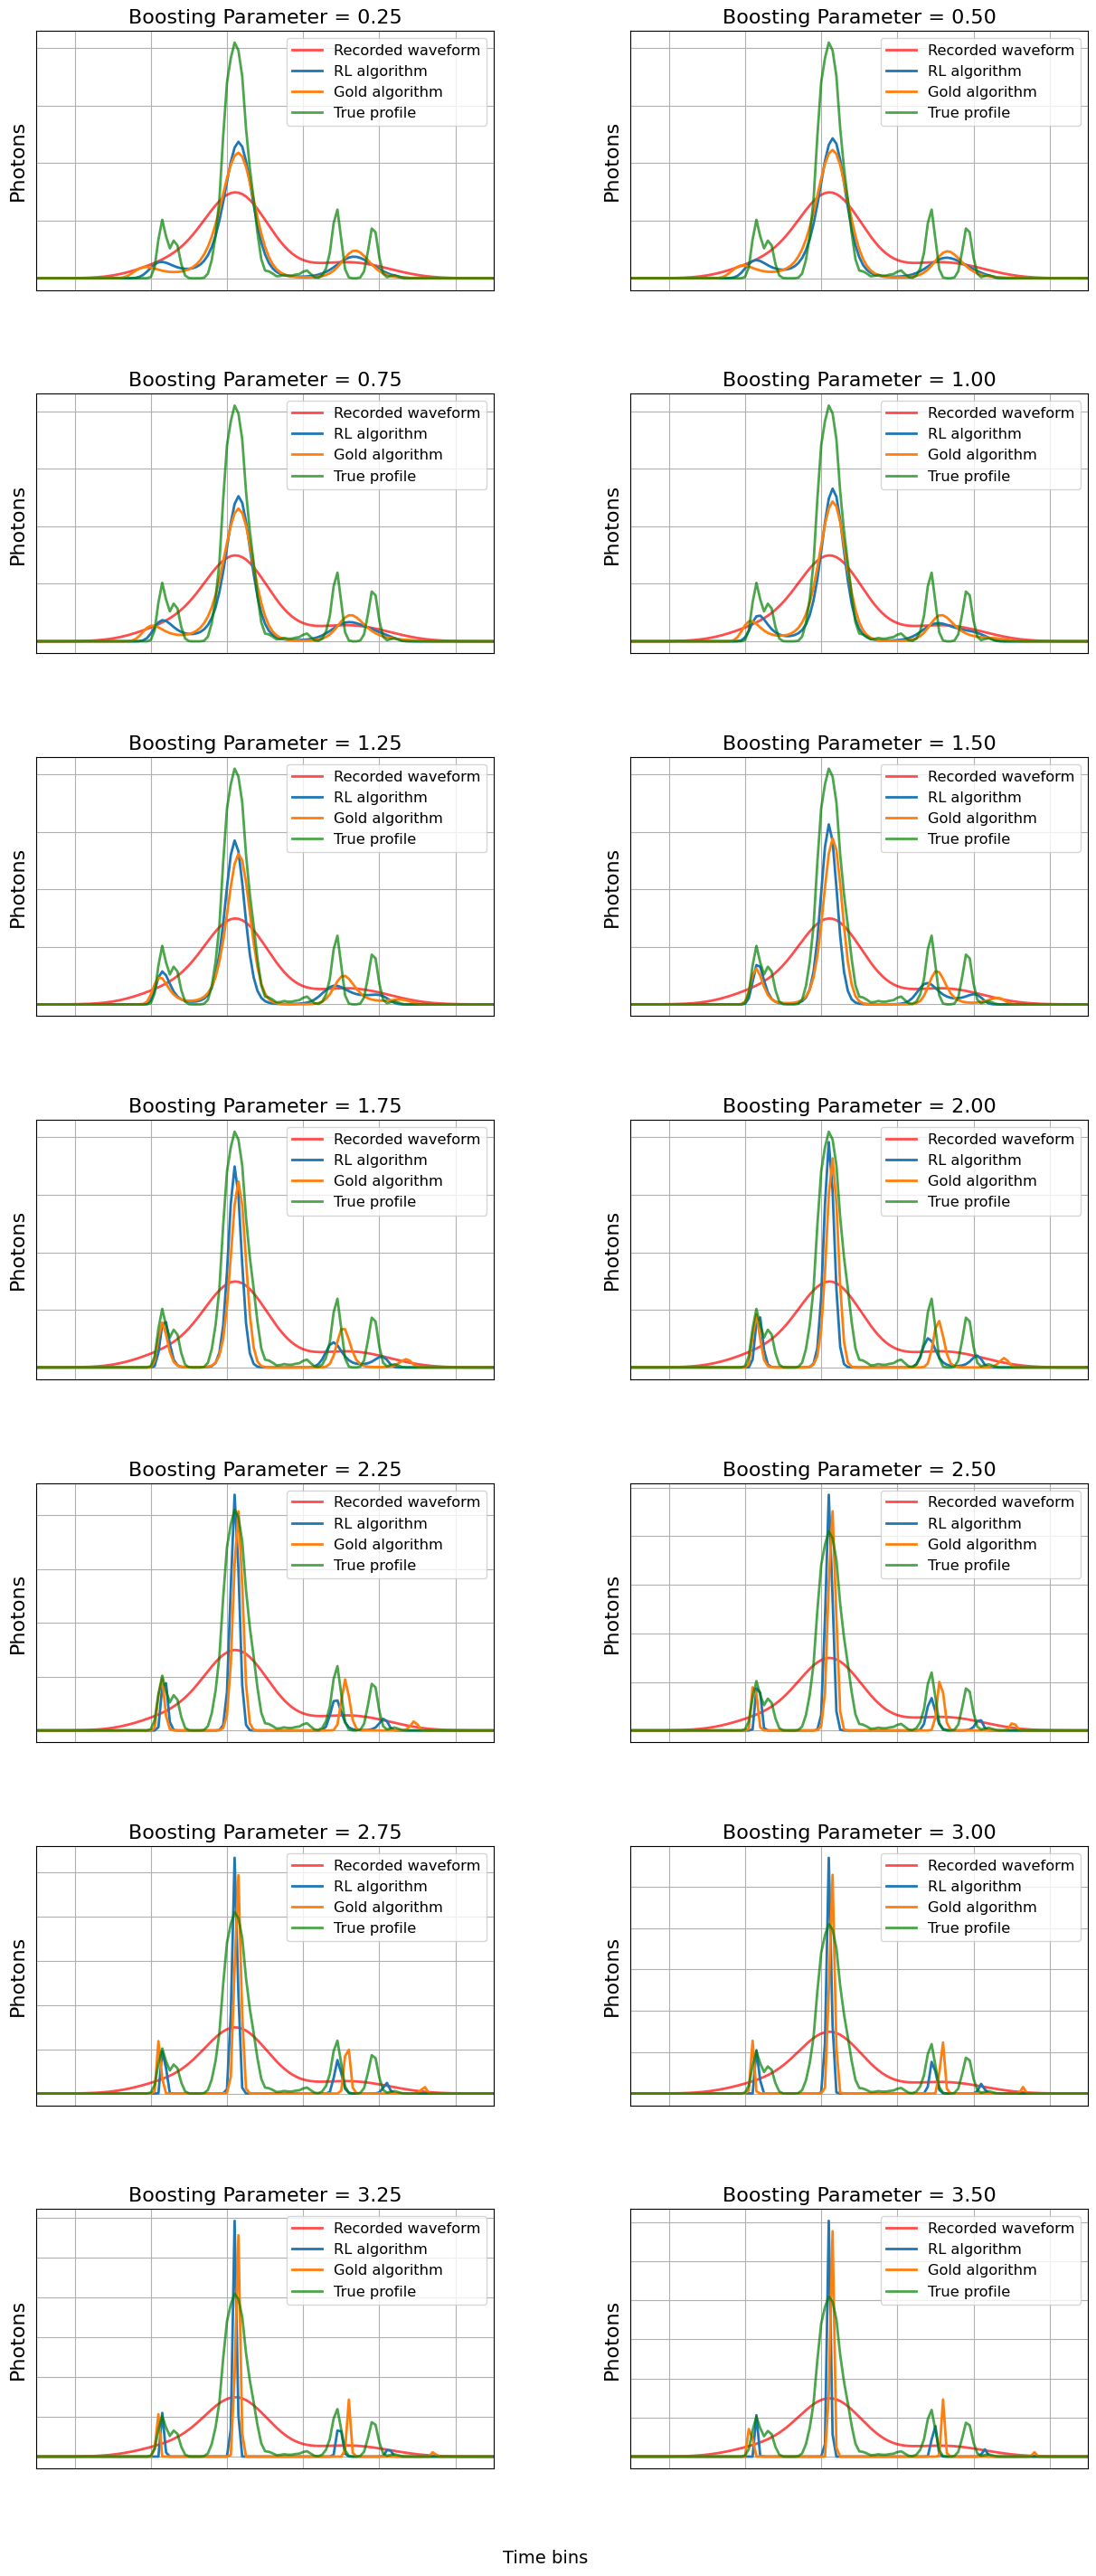

In [10]:
## RL vs Gold Output: And their outcome variation with boosting coefficient/boosting factor

num_iterations = 100
num_repetitions = 5

# 16ns sample
profile = 'profile_20.txt'
P_t_16ns = recorded_waveforms[profile]
true_response = true_waveforms[profile]
R_t_16ns = sys_contr_16ns

# Define boosting factors to vary
boosting_factors = np.arange(0.25, 3.75, 0.25)

# Create subplots
fig, axes = plt.subplots(7, 2, figsize=(15, 35), sharex=True)
fig.subplots_adjust(hspace=0.4, wspace=0.3)

axes = axes.flatten()

for idx, boosting_param in enumerate(boosting_factors):
    # Perform RL and Gold deconvolution with the current boosting factor
    P_deconvolved_RLboosted = richardson_lucy_deconvolution_boosted(P_t_16ns, R_t_16ns, num_iterations, num_repetitions, boosting_param)
    P_deconvolved_goldboosted = boosted_gold_deconvolution(P_t_16ns, R_t_16ns, num_iterations, num_repetitions, boosting_param)

    # Plot the results for this boosting factor
    ax = axes[idx]
    ax.plot(P_t_16ns, label='Recorded waveform', color='red', alpha=0.7, linewidth=2)
    ax.plot(P_deconvolved_RLboosted, label='RL algorithm', linewidth=2)
    ax.plot(P_deconvolved_goldboosted, label='Gold algorithm', linewidth=2)
    ax.plot(true_response, label='True profile', color='green', alpha=0.7, linewidth=2)
    ax.grid(which='both')
    ax.legend(loc='upper right', fontsize='small')
    ax.set_xlim(130, 250)
    ax.set_ylabel('Photons')
    ax.set_title(f'Boosting Parameter = {boosting_param:.2f}')

    # Remove y-axis values
    ax.set_yticklabels([])  # Remove y-axis tick labels
    ax.tick_params(axis='y', which='both', length=0)  # Remove y-axis tick marks

    # Remove x-axis values
    ax.set_xticklabels([])  # Remove x-axis tick labels
    ax.tick_params(axis='x', which='both', length=0)  # Remove x-axis tick marks

# Remove unused subplots
for idx in range(len(boosting_factors), len(axes)):
    fig.delaxes(axes[idx])

# Common x-axis label
fig.text(0.5, 0.08, 'Time bins', ha='center')
plt.show()
